In [1]:
import matplotlib.pyplot as plt
import cv2 as cv
import numpy as np

#### 1. Selecciona una imagen, cárgala en escala de grises dentro del notebook y asígnala a una variable en Python

In [2]:
img = cv.imread('auto.jpg')
img_grises = cv.imread('auto.jpg', cv.IMREAD_GRAYSCALE)

#### 2. Extrae y muestra los puntos de interés SIFT de la imagen del paso anterior, indicando su orientación y escala.

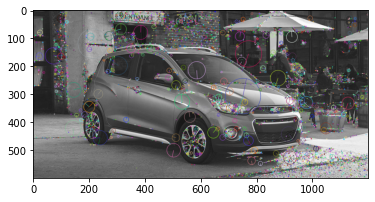

In [3]:
sift = cv.SIFT_create()
kp1, descriptor1 = sift.detectAndCompute(img,None)
img1kp = cv.drawKeypoints(img_grises, kp1, img, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(6,6))
plt.imshow(img1kp)

#### 3. Gira la imagen 60° con la función cv2.warpAffine, extrae y muestra los puntos de interés SIFT

In [7]:
def rotacion_img(img, rot_grad):
    alto, ancho = img.shape[:2]

    esq_sup_izq = (0,0,1)
    esq_inf_izq = (alto,0,1)
    esq_sup_der = (0,ancho,1)
    esq_inf_der = (alto,ancho,1)
    
    centro = (ancho//2, alto//2)
    
    matriz_rot = cv.getRotationMatrix2D(centro, -rot_grad, 1) 
     
    esq_orig = [esq_sup_izq, esq_inf_izq, esq_sup_der, esq_inf_der]
    esq_nueva = [np.matmul(matriz_rot, pt) for pt in esq_orig]
    
    min_x = np.min([pt[0] for pt in esq_nueva])
    max_x = np.max([pt[0] for pt in esq_nueva])
    
    min_y = np.min([pt[1] for pt in esq_nueva])
    max_y = np.max([pt[1] for pt in esq_nueva])
    
    dim_nueva = (int(max_y-min_y), int(max_x-min_x))
    
    centro_nuevo = (dim_nueva[0]//2, dim_nueva[1]//2)
    tras_centro = (centro_nuevo[0]-centro[0], centro_nuevo[1]-centro[1])
    
    matriz_rot[0][2] += tras_centro[0]
    matriz_rot[1][2] += tras_centro[1]
    
    img_rot = cv.warpAffine(img, matriz_rot, dim_nueva)
    return img_rot

In [8]:
img_rotada = rotacion_img(img_grises, 60)

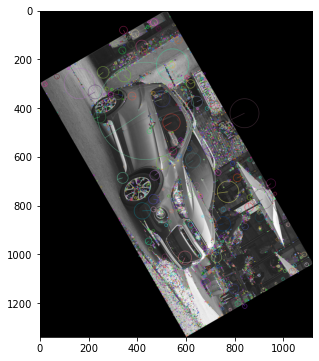

In [9]:
# girar la imagen
img_rotada = rotacion_img(img_grises, 60)

# puntos de interés SIFT de la imagen girada
kp2, descriptor2 = sift.detectAndCompute(img_rotada,None)
img2kp = cv.drawKeypoints(img_rotada, kp2, 0, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt.figure(figsize=(6,6))
plt.imshow(img2kp)


#### 4. Mapea los puntos de interés de las imágenes utilizadas en los pasos 1 y 3. Descarta las coincidencias incorrectas utilizando la prueba de proporción propuesta en el siguiente recurso y muestra las coincidencias entra ambas imágenes con líneas.

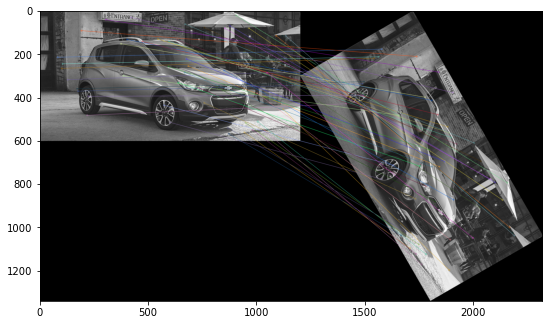

In [10]:
# Coincidencias de caracteristicas
bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)
match1 = bf.match(descriptor1, descriptor2)
match1 = sorted(match1, key=lambda x: x.distance)

img3 = cv.drawMatches(img_grises, kp1, img_rotada, kp2, match1[:50], 0, flags=2)
plt.figure(figsize=(9, 9))
plt.imshow(img3)

#### 5. Utiliza el algoritmo RANSAC para encontrar la transformación afín de la imagen girada hacia la imagen original.

In [24]:
def estima_afin(s, t):
  num = s.shape[1]
  M = np.zeros((2 * num, 6))

  for i in range(num):
    temp = [[s[0, i], s[1, i], 0, 0, 1, 0],
            [0, 0, s[0, i], s[1, i], 0, 1]]
    M[2 * i: 2 * i+2, :] = np.array(temp, dtype=object)

  b = t.T.reshape((2 * num, 1))
  theta = np.linalg.lstsq(M, b)[0]
  X = theta[:4].reshape((2, 2))
  Y = theta[4:]
  return X, Y

In [25]:
K = 3
threshold = 1
ITER_NUM = 2000

def residual_lengths(X, Y, s, t):
  e=np.dot(X, s) + Y
  #e = np.dot(A_tmp, s) + t_tmp
  diff_square = np.power(e - t, 2)
  residual = np.sqrt(np.sum(diff_square, axis=0))
  return residual

def ransac_fit(pts_s, pts_t):
  inliers_num = 0
  A = None
  t = None
  inliers = None
  for i in range(ITER_NUM):
    idx = np.random.randint(0, pts_s.shape[1], (K, 1))
    A_tmp, t_tmp = estima_afin(pts_s[:, idx], pts_t[:, idx])
    residual = residual_lengths(A_tmp, t_tmp, pts_s, pts_t)
    if not(residual is None):
      inliers_tmp = np.where(residual < threshold)
      inliers_num_tmp = len(inliers_tmp[0])
      if inliers_num_tmp > inliers_num:
        inliers_num_tmp = inliers_num_tmp
        inliers = inliers_tmp
        A = A_tmp
        t = t_tmp
      else:
        pass
  return A, t, inliers

In [26]:
def extract_SIFT(img):
  img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  sift = cv.SIFT_create()
  kp, desc = sift.detectAndCompute(img_gray, None)
  kp = np.array([p.pt for p in kp]).T
  return kp, desc

def match_SIFT(descriptor_source, descriptor_target):
  bf = cv.BFMatcher()
  matches = bf.knnMatch(descriptor_source, descriptor_target, k=2)
  pos = np.array([], dtype = np.int32).reshape((0, 2))
  matches_num = len(matches)
  for i in range(matches_num):
    if matches[i][0].distance <= 0.8 * matches[i][1].distance:
      temp = np.array([matches[i][0].queryIdx,
                       matches[i][0].trainIdx])
      pos = np.vstack((pos, temp))
  return pos

def affine_matrix(s, t, pos):
  s = s[:, pos[:, 0]]
  t = t[:, pos[:, 1]]
  _, _, inliers = ransac_fit(s, t)
  s = s[:, inliers[0]]
  t = t[:, inliers[0]]
  A, t = estima_afin(s, t)
  M = np.hstack((A, t))
  return M

In [27]:
def mostrar_imagen(img1, img2, titulo1 = "Original", titulo2 = "Nueva"):
  plt.figure(figsize=(10,10))
  plt.subplot(1,2,1)
  plt.imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
  plt.title(titulo1)
  plt.subplot(1,2,2)
  plt.imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
  plt.title(titulo2)
  plt.show()

C:\Users\Ruben\AppData\Local\Temp\ipykernel_54704\3481944577.py:11: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  theta = np.linalg.lstsq(M, b)[0]


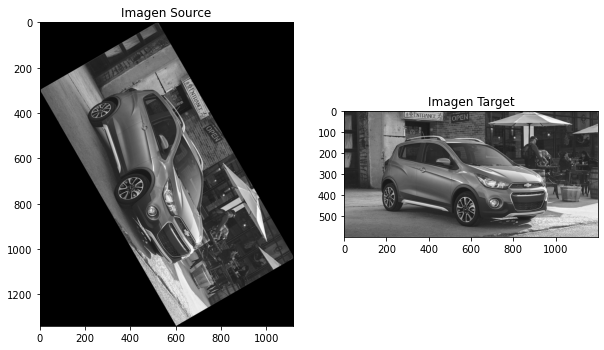

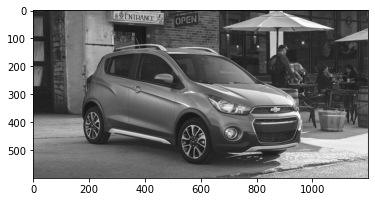

In [28]:
kp1_target = np.array([p.pt for p in kp1]).T
kp2_source = np.array([p.pt for p in kp2]).T # imagen girada

img_target = img_grises
descriptor_target = descriptor1

img_source = img_rotada
descriptor_source = descriptor2


pos = match_SIFT(descriptor_source, descriptor_target)
H = affine_matrix(kp2_source, kp1_target, pos)


rows, cols = img_target.shape
warp = cv.warpAffine(img_source, H, (cols, rows))
merge = np.uint8(img_target * 0.5 + warp * 0.5)

mostrar_imagen(img_source, img_target, titulo1="Imagen Source", titulo2="Imagen Target")
plt.imshow(cv.cvtColor(merge, cv.COLOR_BGR2RGB))

